In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [78]:
class Simulation:
    def __init__(
        self, 
        tmin=1, 
        tstop=None, 
        tmax=20_000, 
        tres=1, 
        tolerance_window=3_000, 
        starting_dose=50, 
        dose_increase=25,
        availability=0.05, 
        threshold=0.01, 
        a=0.25, 
        b=1, 
        alpha1=0.99, 
        alpha2=0.25
    ):
        self.tmin = tmin
        self.tstop = tstop
        self.tmax = tmax
        self.tres = tres
        self.tolerance_window = tolerance_window
        self.starting_dose = starting_dose
        self.dose_increase = dose_increase
        self.availability = availability
        self.threshold = threshold
        self.a = a
        self.b = b
        self.alpha1 = alpha1
        self.alpha2 = alpha2

        self.simulate()
        self.visualize()

    def simulate(self):
        # Prepare data vectors
        time = np.arange(self.tmin, self.tmax, self.tres)
        concinit = 0
        dose = self.starting_dose
        amount_taken = self.starting_dose
        self.conc = np.repeat(0.0, self.tmax)
        self.conc[0] = self.starting_dose
        self.vs_tolerance = np.repeat(0.0, self.tmax)
        self.rolling_tolerance = np.repeat(0.0, self.tmax)
        self.logistic_tolerance = np.repeat(0.0, self.tmax)
        self.effect = np.repeat(0.0, self.tmax)

        # Start the clock
        tprime = 0    # time since last dose, will be updated as we move through time

        for t in time:

            # Add to time since last dose
            tprime += 1

            # Compute concentration of drug using pharmacokinetic model
            self.conc[t] = (concinit + amount_taken) * math.exp(-self.a * tprime)

            # Check if user will take another dose
            if self.tstop is None or t < self.tstop:
                if self.conc[t] < self.threshold:
                    # Check if drug is available
                    if random.uniform(0, 1) < self.availability:
                        concinit = self.conc[t]
                        tprime = 0
                        amount_taken = dose * random.uniform(0.9, 1.1)
                        self.conc[t] = (concinit + amount_taken) * math.exp(-self.a * tprime)

            # Compute Virtual Smoker version tolerance
            self.vs_tolerance[t] = self.alpha1 * self.vs_tolerance[t-1] + self.alpha2 * self.conc[t]

            # Compute rolling dose-based tolerance
            if t < self.tolerance_window:
                to_pad = self.tolerance_window - t
                pad = np.repeat(0, to_pad)
                self.rolling_tolerance[t] = np.mean(np.append(self.conc[:t], pad)) * 3
            else:
                self.rolling_tolerance[t] = np.mean(self.conc[t-self.tolerance_window:t]) * 3

            # Compute logistic tolerance
            def logistic(x, L, k, x0):
                '''
                L is the curve's maximum value
                k is the logistic growth rate or steepness of the curve
                x0 is the x value at the sigmoid's midpoint
                '''
                y = L / (1 + np.exp(-k * (x - x0)))
                return y

            self.logistic_tolerance[t] = logistic(self.rolling_tolerance[t], L=(dose**1.1)*0.45, k=0.2-(dose*0.0002), x0=dose*.175) 


            # Compute effect
            self.effect[t] = (concinit + amount_taken - self.logistic_tolerance[t]) * math.exp(-self.a * tprime)
            # effect[t] = max(conc[t] - rolling_tolerance[t], 0)
            # effect[t] = conc[t] - rolling_tolerance[t]

            # Check if user will increase dose
            if tprime == 1 and self.effect[t] < (dose * 0.25):
                if dose < 2_000:
                    dose += self.dose_increase

    def visualize(self):
        fig, ax = plt.subplots(figsize=(15,8))
        plt.plot(self.conc, label='concentration')
        plt.plot(self.rolling_tolerance, label='rolling tolerance', zorder=3)
        plt.plot(self.logistic_tolerance, label='logistic tolerance', zorder=4)
        # plt.plot(vs_tolerance, label='tolerance')
        plt.plot(self.effect, label='effect')
        plt.legend()
        plt.xlabel('Day') 
        plt.ylabel('Dose, MME')
        locs, labels = plt.xticks()

        scale = 100
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale))
        ax.xaxis.set_major_formatter(ticks_x)


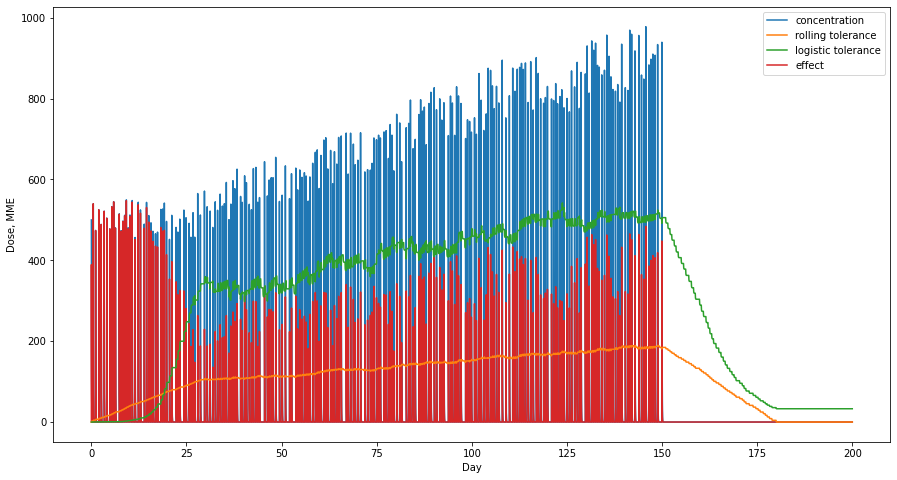

In [90]:
Simulation(starting_dose=500, tstop=15_000)

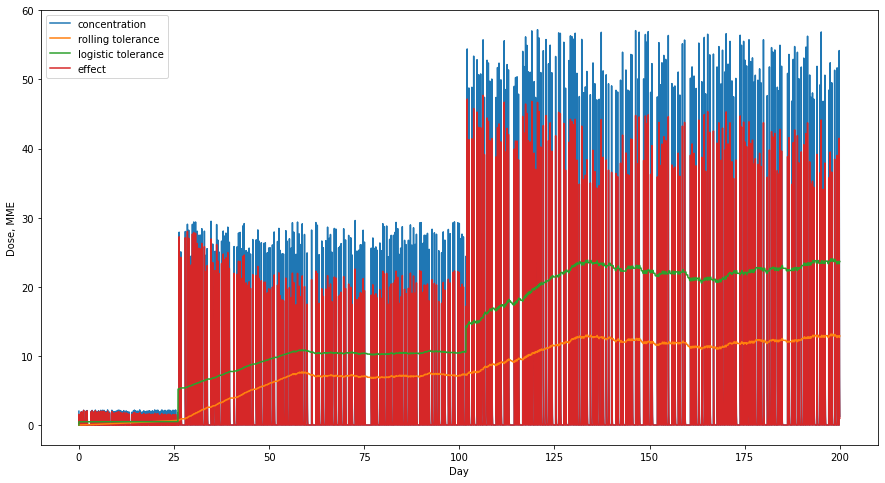

In [61]:
Simulation(starting_dose=2)

### Reduced availability limits tolerance building

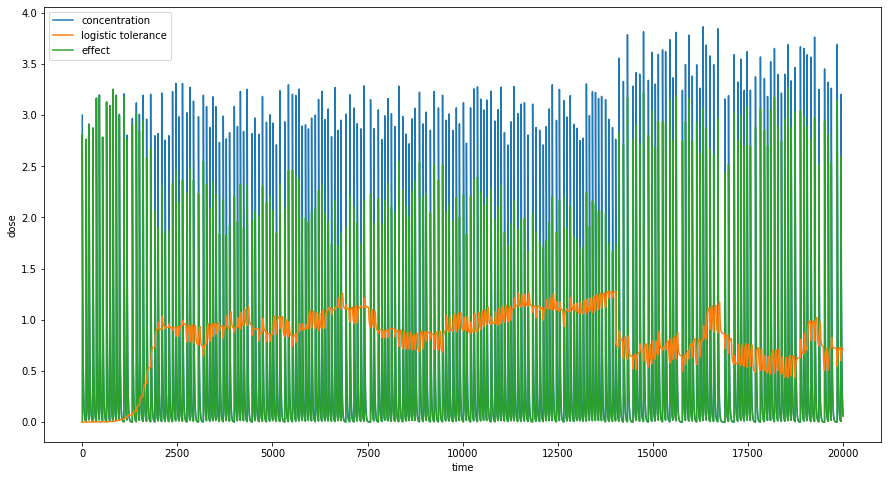

In [51]:
Simulation(starting_dose=3, availability=0.05)

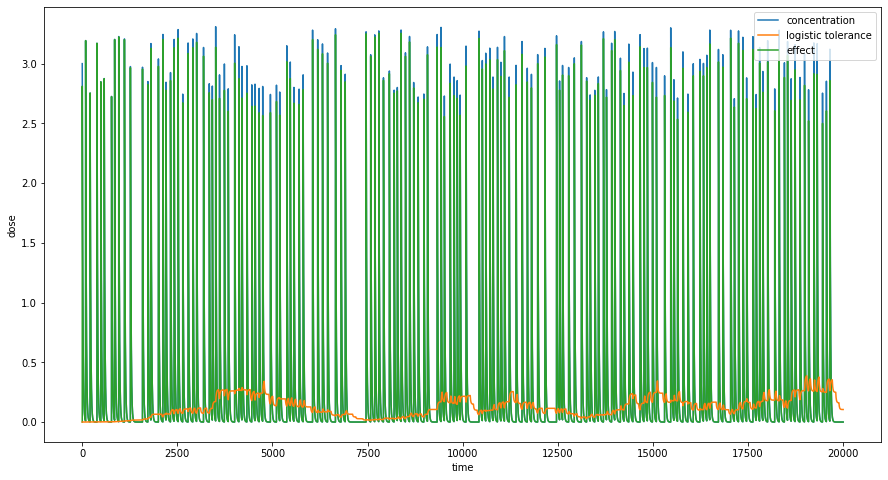

In [52]:
Simulation(starting_dose=3, availability=0.02)


### Tolerance drops off quickly after stopping use
#### (In this example somewhere around 10 days)

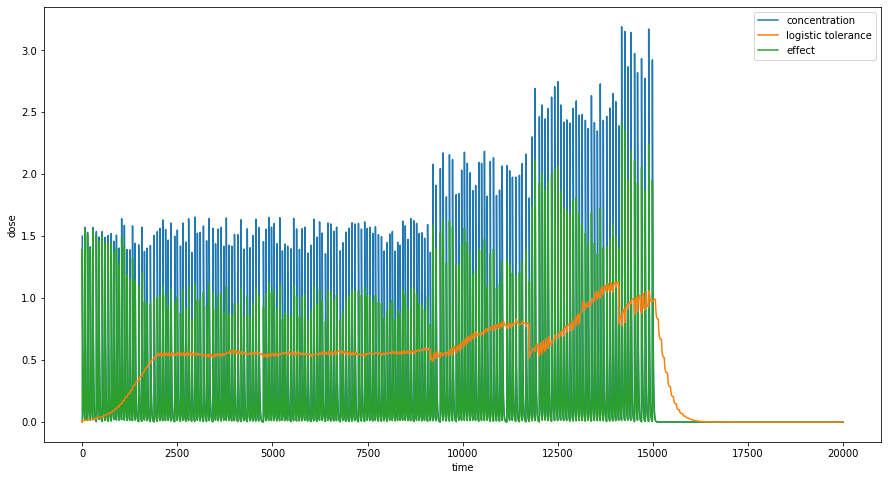

In [53]:
Simulation(starting_dose=1.5, tstop=15_000)